## Setup

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.callbacks import *

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-09-22 13:30:17.254049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 13:30:17.361937: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 13:30:18.136436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-22 13:30:18.136485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Hyperparameters

In [4]:
batch_size = 256
num_epochs = 800         # Just for the sake of demonstration
total_timesteps = 1000   # 1000
norm_groups = 8          # Number of groups used in GroupNormalization layer
learning_rate = 1e-4

img_size_H = 32
img_size_W = 64
img_channels = 5

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

## Gaussian diffusion utilities

We define the **forward process** and the **reverse process** as a separate utility. Most of the code in this utility has been borrowed
from the original implementation with some slight modifications.

In [5]:
from layers.diffusion import GaussianDiffusion

## Network architecture

U-Net, originally developed for semantic segmentation, is an architecture that is
widely used for implementing diffusion models but with some slight modifications:

1. The network accepts two inputs: Image and time step
2. Self-attention between the convolution blocks once we reach a specific resolution
(16x16 in the paper)
3. Group Normalization instead of weight normalization

We implement most of the things as used in the original paper. We use the
`swish` activation function throughout the network. We use the variance scaling
kernel initializer.

The only difference here is the number of groups used for the
`GroupNormalization` layer. For the flowers dataset,
we found that a value of `groups=8` produces better results
compared to the default value of `groups=32`. Dropout is optional and should be
used where chances of over fitting is high. In the paper, the authors used dropout
only when training on CIFAR10.

In [6]:
from tensorflow.keras.models import load_model

pretrained_encoder = load_model('../saved_models/encoder_cnn_56deg_5var.h5')
# pretrained_encoder.summary()

2024-09-22 13:30:19.704759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 13:30:19.867537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:d5:00.0, compute capability: 8.0


In [7]:
# Extract the first 5 layers
first_five_layers = pretrained_encoder.layers[:5]

# Display the first four layers to confirm
for i, layer in enumerate(first_five_layers):
    print(f"Layer {i}: {layer}")

# Create a new model using these layers
# Get the input of the pre-trained model
input_layer = pretrained_encoder.input

# Get the output of the fourth layer
output_layer = first_five_layers[-1].output

# Create the new model
pretrained_encoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Print the summary of the new model
pretrained_encoder.summary()

Layer 0: <keras.engine.input_layer.InputLayer object at 0x7fc6f3f53a30>
Layer 1: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8ac25dba0>
Layer 2: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8adef8940>
Layer 3: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc6f360c5b0>
Layer 4: <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc6f360cb80>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 64, 5)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 64, 32)        672       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 64, 128)       16512     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 64, 256)       131328    
           

In [8]:
for layer in pretrained_encoder.layers:
    layer.trainable = False

pretrained_encoder._name = 'encoder'

In [9]:
from layers.denoiser import build_unet_model_c2

In [10]:
# Build the unet model
network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)

image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)


In [11]:
# network.summary()

## Training

In [12]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network  # denoiser or noise predictor
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, data):
        # Unpack the data
        (images, image_input_past1, image_input_past2), y = data
        
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]
        
        # 2. Sample timesteps uniformly
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
            print("noise.shape:", noise.shape)
            
            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)
            print("images_t.shape:", images_t.shape)
            
            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t, image_input_past1, image_input_past2], training=True)
            print("pred_noise.shape:", pred_noise.shape)
            
            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    
    def test_step(self, data):
        # Unpack the data
        (images, image_input_past1, image_input_past2), y = data

        # 1. Get the batch size
        batch_size = tf.shape(images)[0]
        
        # 2. Sample timesteps uniformly
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)

        # 3. Sample random noise to be added to the images in the batch
        noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
        
        # 4. Diffuse the images with noise
        images_t = self.gdf_util.q_sample(images, t, noise)
        
        # 5. Pass the diffused images and time steps to the network
        pred_noise = self.network([images_t, t, image_input_past1, image_input_past2], training=False)
        
        # 6. Calculate the loss
        loss = self.loss(noise, pred_noise)

        # 7. Return loss values
        return {"loss": loss}



# Build the unet model
network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)

ema_network = build_unet_model_c2(
    img_size_H=img_size_H,
    img_size_W=img_size_W,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    first_conv_channels=first_conv_channels,
    activation_fn=keras.activations.swish,
    encoder=pretrained_encoder,
)
ema_network.set_weights(network.get_weights())  # Initially the weights are the same

image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)
image_input_past_embed1 shape: (None, 32, 64, 64)
image_input_past_embed2 shape: (None, 32, 64, 64)
image_input_past shape: (None, 32, 64, 64)
image_input_past shape: (None, 2048, 64)
x.shape: (None, 32, 64, 64) temb.shape: (None, 256)


In [13]:
# ema_network.summary()

### Load trained model

In [14]:
# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    ema_network=ema_network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

In [15]:
# Restore weights
model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3')  # full version of CoDiCast 1000 steps
# model.load_weights('../checkpoints/ddpm_weather_56c2_56_5var_cp3_1000')  # full version of CoDiCast 1000 steps

## Results

In [16]:
from utils.normalization import batch_norm, batch_norm_reverse
from utils.metrics import lat_weighted_rmse_one_var, lat_weighted_acc_one_var

In [17]:
resolution_folder = '56degree'
resolution = '5.625'  
var_num = '5'

test_data_tf = np.load("data/concat_2017_2018_" + resolution + "_" + var_num + "var.npy")
test_data_tf = test_data_tf.transpose((0, 2, 3, 1))
test_data_tf.shape

(2920, 32, 64, 5)

In [18]:
test_data_tf_norm = batch_norm(test_data_tf, test_data_tf.shape, batch_size=1460)
test_data_tf_norm.shape

(2920, 32, 64, 5)

In [19]:
test_data_tf_norm_pred = test_data_tf_norm[2:]
test_data_tf_norm_past1 = test_data_tf_norm[:-2]
test_data_tf_norm_past2 = test_data_tf_norm[1:-1]

print(test_data_tf_norm_pred.shape, test_data_tf_norm_past1.shape, test_data_tf_norm_past2.shape)

(2918, 32, 64, 5) (2918, 32, 64, 5) (2918, 32, 64, 5)


### One example of t+6 ~ t+72

In [20]:
import tensorflow as tf
import numpy as np

def generate_images(model, original_samples, original_samples_past1, original_samples_past2):
    """
    @model: trained denoiser
    @original_samples: it just provides the shape, does not involve generation
    @original_samples_past: conditions from the past
    """
    num_images = original_samples.shape[0]
    img_size_H = original_samples.shape[1]
    img_size_W = original_samples.shape[2]
    img_channels = original_samples.shape[3]
    total_timesteps = model.timesteps  # Ensure this is defined in your model

    # 1. Randomly sample noise (starting point for reverse process)
    samples = tf.random.normal(shape=(num_images, img_size_H, img_size_W, img_channels), dtype=tf.float32)
    
    # 2. Sample from the model iteratively
    for t in reversed(range(0, total_timesteps)):
        tt = tf.cast(tf.fill([num_images], t), dtype=tf.int64)
        pred_noise = model.ema_network.predict([samples, tt, original_samples_past1, original_samples_past2],
                                               verbose=0, 
                                               batch_size=num_images
                                              )
        samples = model.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)
        
    # 3. Return generated samples and original samples
    return original_samples, samples
    # return original_samples.numpy(), samples.numpy()

In [21]:
gen_start_idx = 0
gen_end_idx = 12

original_samples = tf.convert_to_tensor(test_data_tf_norm_pred[gen_start_idx:gen_end_idx], dtype=tf.float32)
original_samples_past1 = tf.convert_to_tensor(test_data_tf_norm_past1[gen_start_idx:gen_end_idx], dtype=tf.float32)
original_samples_past2 = tf.convert_to_tensor(test_data_tf_norm_past2[gen_start_idx:gen_end_idx], dtype=tf.float32)

print(original_samples.shape, original_samples_past1.shape, original_samples_past2.shape)

(12, 32, 64, 5) (12, 32, 64, 5) (12, 32, 64, 5)


In [22]:
import time


def predict_autoregressive(model, initial_inputs, prediction_horizon):
    
    predictions = []
    
    original_sample, sample_past1, sample_past2 = initial_inputs[0], initial_inputs[1], initial_inputs[2]  # t, t-2, t-1

    start_time = time.time()
    
    for _ in range(prediction_horizon):
        # Predict the next time step
        original_sample, generated_sample = generate_images(model, original_sample, sample_past1, sample_past2)
        
        print("original_sample.shape:", original_sample.shape, "generated_sample.shape:", generated_sample.shape)
        
        # Append the prediction to the list of predictions
        predictions.append(generated_sample)

        sample_past1 = sample_past2
        sample_past2 = generated_sample
        
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Generating 12 samples use {epoch_duration:.2f} s')
    
    # Concatenate predictions along the time steps axis
    predictions = np.concatenate(predictions, axis=0)
    return predictions

### Ensemble forecast

In [ ]:
ens_num = 20
num_sample = 5  # this should be the number of entire test samples, 5 here is only for the sake of representation
prediction_horizon = 12

for j in range(1, num_sample+1):  # number of sample
    print(f'========= sample {j} ========= \n')
    for i in range(1, ens_num+1):
        print(f'========= ensenble {i} ========= \n')
        initial_inputs = [tf.convert_to_tensor(original_samples[j:j+1], dtype=tf.float32),
                      tf.convert_to_tensor(original_samples_past1[j:j+1], dtype=tf.float32), 
                      tf.convert_to_tensor(original_samples_past2[j:j+1], dtype=tf.float32)
                     ]  # t, t-2, t-1
    
        future_predictions = predict_autoregressive(model, initial_inputs, prediction_horizon)
        print(future_predictions.shape)
    
        original_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, original_samples)
        generated_samples_unnormlalized = batch_norm_reverse(test_data_tf, test_data_tf.shape, 1459, future_predictions)
        print(original_samples_unnormlalized.shape, generated_samples_unnormlalized.shape)
    
        np.save(f'ensemble/generated_samples_unnormlalized_{j}_{i}.npy', generated_samples_unnormlalized)
        np.save(f'ensemble/original_samples_unnormlalized{j}.npy', original_samples_unnormlalized)

========= sample 1 ========= 

original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
original_sample.shape: (1, 32, 64, 5) generated_sample.shape: (1, 32, 64, 5)
Generating 12 samples use 1761.13 s
(12, 32, 

In [47]:
original_samples_unnormlalized_1 = np.load('ensemble/original_samples_unnormlalized.npy')
original_samples_unnormlalized_1.shape

(12, 32, 64, 5)

In [44]:
ens_preds = []

for i in range(1, ens_num):
    each_pred = np.load(f'ensemble/generated_samples_unnormlalized_{i}.npy')
    ens_preds.append(each_pred)

In [45]:
ens_preds[0].shape

(12, 32, 64, 5)

In [46]:
ens_preds_concat1 = np.stack(ens_preds, axis=-1)
ens_preds_concat1.shape

(12, 32, 64, 5, 19)

(12,) (12, 20)


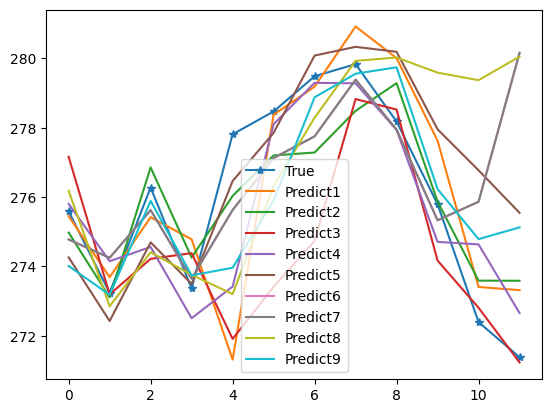

In [263]:
lat_index = 8
lon_index = 16
var_idx = 1

truth = original_samples_unnormlalized_1[:, lat_index, lon_index, var_idx]
ens_preds_concat = ens_preds_concat1[:, lat_index, lon_index, var_idx, :]
print(truth.shape, ens_preds_concat.shape)

plt.plot(truth, label='True', marker='*')
for i in range(1, 10):
    plt.plot(ens_preds_concat[:,i], label=f'Predict{i}')

plt.legend()
# plt.ylim(260, 285)

mean_prediction: (12,), min_prediction: (12,), max_prediction: (12,)
std_prediction: (12,)


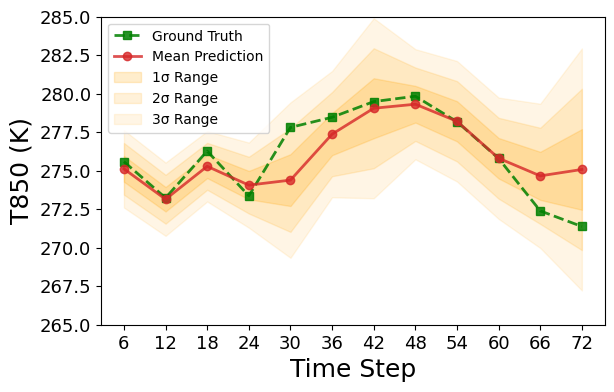

In [286]:
# Calculate mean, min, max of predictions
mean_prediction = np.mean(ens_preds_concat, axis=-1)
min_prediction = np.min(ens_preds_concat, axis=-1)
max_prediction = np.max(ens_preds_concat, axis=-1)
print(f"mean_prediction: {mean_prediction.shape}, min_prediction: {min_prediction.shape}, max_prediction: {max_prediction.shape}")

# Calculate standard deviation of predictions
std_prediction = np.std(ens_preds_concat, axis=-1)
print(f"std_prediction: {std_prediction.shape}")

# Define sigma ranges (1σ, 2σ, 3σ)
one_sigma_upper = mean_prediction + std_prediction
one_sigma_lower = mean_prediction - std_prediction
two_sigma_upper = mean_prediction + 2 * std_prediction
two_sigma_lower = mean_prediction - 2 * std_prediction
three_sigma_upper = mean_prediction + 3 * std_prediction
three_sigma_lower = mean_prediction - 3 * std_prediction

# Plotting
plt.figure(figsize=(6.5, 4))

# Plot ground truth
plt.plot(range(12), truth, label="Ground Truth", color="green", linestyle="--", linewidth=2, marker='s', alpha=0.85)

# Plot mean prediction
plt.plot(range(12), mean_prediction, label="Mean Prediction", color="tab:red", linestyle="-", linewidth=2, marker='o', alpha=0.8)

# Plot 1σ range
plt.fill_between(range(12), one_sigma_lower, one_sigma_upper, color="orange", alpha=0.2, label="1σ Range")

# Plot 2σ range
plt.fill_between(range(12), two_sigma_lower, two_sigma_upper, color="orange", alpha=0.15, label="2σ Range")

# Plot 3σ range
plt.fill_between(range(12), three_sigma_lower, three_sigma_upper, color="orange", alpha=0.1, label="3σ Range")



# # Plot individual predictions (optional)
# for i in range(ens_preds_concat.shape[0]):
#     plt.plot(range(12), ens_preds_concat[i], color="gray", linestyle=":", alpha=0.5)


# Set custom x-ticks
# xticks = [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]
xticks = [i for i in range(6, 73, 6)]
plt.xticks(ticks=range(12), labels=xticks, fontsize=13)
plt.yticks(fontsize=13)


# Add labels and legend
plt.xlabel("Time Step", fontsize=18)
plt.ylabel("T850 (K)", fontsize=18)
plt.ylim(265, 285)
# plt.title("Forecast with Estimated Uncertainty", fontsize=18)
plt.legend()

# Show plot
plt.show()

### CRPS for one test sample

In [33]:
import numpy as np
import properscoring as ps
from scipy.stats import norm

In [137]:
generated_samples_unnormlalized_concat = np.stack(ens_preds, axis=-1)
generated_samples_unnormlalized_concat.shape

(12, 32, 64, 5, 20)

In [138]:
crps = ps.crps_ensemble(original_samples_unnormlalized_1, generated_samples_unnormlalized_concat)
crps.shape

(12, 32, 64, 5)

In [139]:
for i in range(crps.shape[-1]):
    print(crps[:,:,:,i].mean(axis=(1,2)))
    print('\n')

[ 39.15192701  63.17688381  87.9969521  111.09377752 137.54095521
 157.54429109 177.4458099  191.20049686 207.98537556 223.31588923
 241.34665706 263.39382683]


[0.49697641 0.58976673 0.66153301 0.73826427 0.83862034 0.89728494
 0.94878983 0.98846828 1.0594628  1.15139832 1.20930766 1.30793136]


[0.4484221  0.568216   0.63534714 0.69223499 0.76881383 0.82836486
 0.84805451 0.90554313 0.98466123 1.04115007 1.06257543 1.11393434]


[0.53456079 0.63841656 0.73117246 0.81344819 0.93186034 1.02803443
 1.18355593 1.30808668 1.41494185 1.49738482 1.54876521 1.64623983]


[0.5179996  0.6574285  0.73343288 0.86177259 0.99398061 1.0757253
 1.14833311 1.28868872 1.41859008 1.54528402 1.58837425 1.69628967]


